In [34]:
#from dadapy import data
import torchvision
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from collections import namedtuple
import numpy as np
from urllib.request import urlretrieve
from os.path import exists, isdir
from os import makedirs

In [12]:
def fetch_kmnist(data_path = "kmnist", force_download = True):
    """Function that fetches the train and test kmnist dataset and returns it in a numpy array.
    It downloads it if the file is not present or if force_download is True."""
    
    url = 'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-'
    train_url = url + 'train-imgs.npz'
    test_url  = url + 'test-imgs.npz'
    
    train_path = data_path + "/train_set"
    test_path  = data_path + "/test_set"
    
    if not isdir(data_path):
        makedirs(data_path)
    
    if not exists(train_path) or force_download:
        print(f"downloading data from {train_url} to {train_path}")
        urlretrieve(train_url, train_path)
    if not exists(test_path) or force_download:
        print(f"downloading data from {test_url} to {test_path}")
        urlretrieve(test_url, test_path)
    
    train_set = np.load(train_path)['arr_0']
    test_set  = np.load(test_path)['arr_0']
        
    return train_set, test_set

In [58]:
train_set, test_set = fetch_kmnist(force_download = False)
train_set_flat = train_set.reshape(-1,28*28)

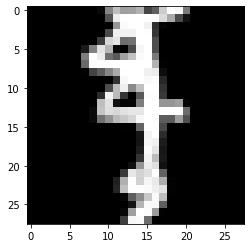

In [59]:
first_img=train_set_flat[3454]
_ = plt.imshow(first_img.reshape(28,28), cmap='gray')

In [17]:
# _data = data.Data(train_set_flat)
# estimate ID
# id_twoNN, _, r = _data.compute_id_2NN()
id_twoNN = 21

In [25]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2),
            torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 2, padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride = 1),
            torch.nn.Flatten(),
            torch.nn.Linear(6*6*64, id_twoNN)
        )
    
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(id_twoNN, 64*8*8),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, torch.Size([64, 8, 8])),
            torch.nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 2, stride = 2, padding = 1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels = 32, out_channels = 1, kernel_size = 2, stride = 2, padding = 0),
            torch.nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

In [26]:
model = AE()

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss = torch.nn.MSELoss(reduction = 'sum')

In [28]:
url = "http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz"
urlretrieve(url, "kmnist/train_label")
train_labels = np.load("kmnist/train_label")['arr_0']

In [60]:
batch_size = 512
torch_train_set = TensorDataset(torch.Tensor(train_set)) # create your datset
train_dataloader = DataLoader(torch_train_set, batch_size=batch_size, shuffle=True)

torch_test_set = TensorDataset(torch.Tensor(test_set)) # create your datset
test_dataloader = DataLoader(torch_test_set, batch_size=batch_size, shuffle=True)

In [61]:
next(iter(train_dataloader))[0].shape

torch.Size([512, 28, 28])

In [62]:
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x in iter(train_dataloader):
        x_hat = model(x)
        l = loss(x_hat,x)
        train_loss += l.item()
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print("Epoch "+ str(epoch+1) + " Training loss:" + str(train_loss / (len(train_dataloader.dataset))))
    
with torch.no_grad():
    model.eval()
    test_loss=0 
    for x in iter(test_dataloader):
            x_hat=model(x)
            l=loss(x_hat,x)
            test_loss+=l.item()
    test_loss /= len(testloader.dataset)
    print("Test set loss:"+str(test_loss))

TypeError: conv2d() received an invalid combination of arguments - got (list, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mlist[0m, [31;1mParameter[0m, [31;1mParameter[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mlist[0m, [31;1mParameter[0m, [31;1mParameter[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)
